In [1]:
import utils
import get_data
import pandas as pd
import numpy as np

In [2]:
df = utils.read("raw_data.ser")
df.head()
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'TypicalPrice'],
      dtype='object')

In [3]:
list_of_cols_to_normalize = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "TypicalPrice"]

# Apply the calculate_gt function to each ticker group
for col in list_of_cols_to_normalize:
    df = df.groupby('Ticker').apply(lambda group: get_data.percent_diff(group, col)).reset_index(drop=True)

df_after_normalizing = df

In [4]:
df = df_after_normalizing #.drop(columns=["Year", "Month", "Day", "Weekday"])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,TypicalPrice
0,1999-11-30,0.024390,0.011782,0.009245,0.001484,0.001483,0.057742,A,0.007492
1,1999-12-01,0.004464,0.011645,0.022901,0.017778,0.017778,-0.313850,A,0.017353
2,1999-12-02,0.037037,0.035971,0.031343,0.027656,0.027657,0.038054,A,0.031676
3,1999-12-03,0.027143,0.015278,0.026049,0.008499,0.008498,-0.009199,A,0.016533
4,1999-12-06,0.006954,0.016416,0.019746,0.028090,0.028090,-0.260008,A,0.021375


In [5]:
df.rename(columns={'TypicalPrice': 'gt'}, inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,gt
0,1999-11-30,0.024390,0.011782,0.009245,0.001484,0.001483,0.057742,A,0.007492
1,1999-12-01,0.004464,0.011645,0.022901,0.017778,0.017778,-0.313850,A,0.017353
2,1999-12-02,0.037037,0.035971,0.031343,0.027656,0.027657,0.038054,A,0.031676
3,1999-12-03,0.027143,0.015278,0.026049,0.008499,0.008498,-0.009199,A,0.016533
4,1999-12-06,0.006954,0.016416,0.019746,0.028090,0.028090,-0.260008,A,0.021375


In [10]:
def find_missing_dates(group):
    start_date = group['Date'].min()
    end_date = group['Date'].max()
    all_business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    return all_business_days[~all_business_days.isin(group['Date'])]

missing_dates = df.groupby('Ticker').apply(find_missing_dates)


In [7]:
def resample_ticker_group(group):
    group = group.set_index('Date')
    ticker_value = group['Ticker'].iloc[0] 
    group = group.resample('B').asfreq()
    # print("before", group)
    group.interpolate(method='linear', axis=0, inplace=True)
    group['Ticker'].fillna(ticker_value, inplace=True)
    # print("after", group)
    return group.reset_index() # Reset the index to keep 'Date' as a column

newdf = df.groupby('Ticker', group_keys=False).apply(resample_ticker_group)
print(newdf.shape)
newdf.head()

(3794432, 9)


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,gt
0,1999-11-30,0.024390,0.011782,0.009245,0.001484,0.001483,0.057742,A,0.007492
1,1999-12-01,0.004464,0.011645,0.022901,0.017778,0.017778,-0.313850,A,0.017353
2,1999-12-02,0.037037,0.035971,0.031343,0.027656,0.027657,0.038054,A,0.031676
3,1999-12-03,0.027143,0.015278,0.026049,0.008499,0.008498,-0.009199,A,0.016533
4,1999-12-06,0.006954,0.016416,0.019746,0.028090,0.028090,-0.260008,A,0.021375


In [8]:
df = newdf
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek % 7

df["Year"] = (df["Year"] - 1900) / 150 
df["Month"] = (df["Month"] - 1) / 12 # [1, 12]
df["Day"] = (df["Day"] - 1) / 31 # [1, 31]
df["Weekday"] = df["Weekday"] / 5 # [0, 4]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,gt,Year,Month,Day,Weekday
0,1999-11-30,0.024390,0.011782,0.009245,0.001484,0.001483,0.057742,A,0.007492,0.66,0.833333,0.935484,0.2
1,1999-12-01,0.004464,0.011645,0.022901,0.017778,0.017778,-0.313850,A,0.017353,0.66,0.916667,0.000000,0.4
2,1999-12-02,0.037037,0.035971,0.031343,0.027656,0.027657,0.038054,A,0.031676,0.66,0.916667,0.032258,0.6
3,1999-12-03,0.027143,0.015278,0.026049,0.008499,0.008498,-0.009199,A,0.016533,0.66,0.916667,0.064516,0.8
4,1999-12-06,0.006954,0.016416,0.019746,0.028090,0.028090,-0.260008,A,0.021375,0.66,0.916667,0.161290,0.0


In [10]:
inf_counts = np.isinf(df.drop(columns=["Ticker"])).sum()
print(inf_counts)

utils.write(df, "SNPdata.ser")

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
gt           0
Year         0
Month        0
Day          0
Weekday      0
dtype: int64


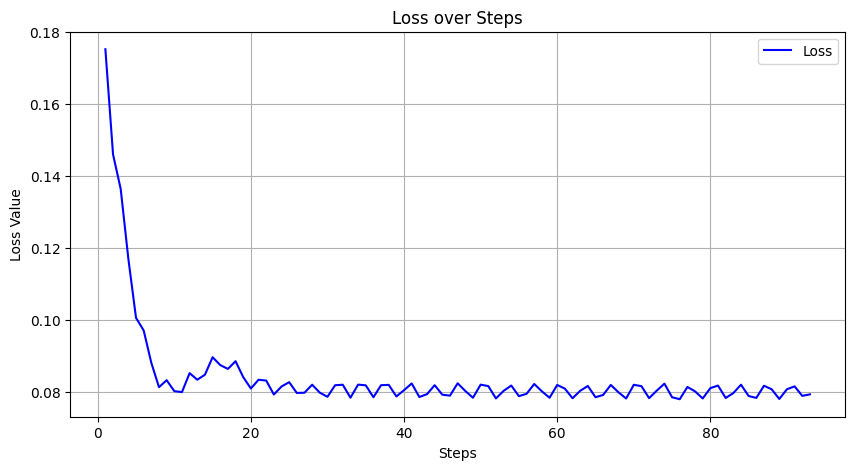

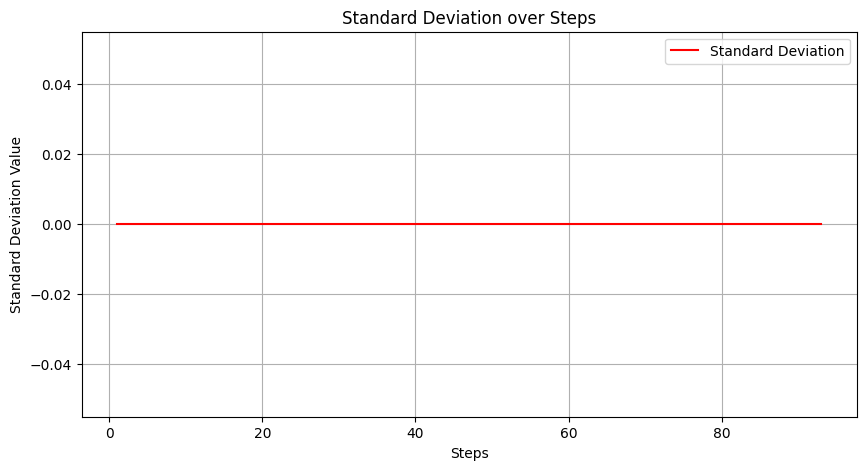

In [5]:
import matplotlib.pyplot as plt
import os

# Read the file
checkpoint_dir = "/data/katop1234/FPT2/serialized/checkpoints/batch_4096_lr_1e-06_input_256_embed_256_depth_4/"
losses_pth = os.path.join(checkpoint_dir, "losses.txt")
with open(losses_pth, "r") as f:
    lines = f.readlines()

# Extract loss and std dev values
losses = []
std_devs = []

for line in lines:
    if "Loss:" in line and "Std Dev:" in line:
        parts = line.split(',')
        loss = float(parts[0].split(":")[1].strip())
        std_dev = float(parts[1].split(":")[1].strip())
        
        losses.append(loss)
        std_devs.append(std_dev)

# Plotting
steps = list(range(1, len(losses) + 1))

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Loss', color='blue')
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title('Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

# Plot Std Dev
plt.figure(figsize=(10, 5))
plt.plot(steps, std_devs, label='Standard Deviation', color='red')
plt.xlabel('Steps')
plt.ylabel('Standard Deviation Value')
plt.title('Standard Deviation over Steps')
plt.legend()
plt.grid(True)
plt.show()
